# FlowKit Tutorial - Part 3 - The `GatingStrategy` & `GatingResults` Classes

https://flowkit.readthedocs.io/en/latest/?badge=latest

So far, we've seen how to load FCS files using the Sample class and perform basic pre-processing like compensation and transformation for better visualization of event data. In part 3, we will explore using FlowKit for gating Sample event data using the `GatingStrategy` and `GatingResults` classes.

If you have any questions about FlowKit, find any bugs, or feel something is missing from these tutorials [please submit an issue to the GitHub repository here](https://github.com/whitews/FlowKit/issues/new/).

## Table of Contents

* [GatingStrategy Class](#GatingStrategy-Class)
  * [The Gate ID Concept](#The-Gate-ID-Concept)
  * [Create a GatingStrategy from GatingML Document](#Create-a-GatingStrategy-from-GatingML-Document)
    * [Retrieve the Gate Hierarchy](#Retrieve-the-Gate-Hierarchy)
    * [Export Gate Hierarchy as Image](#Export-Gate-Hierarchy-as-Image)
    * [Retrieve Gate IDs](#Retrieve-Gate-IDs)
    * [Retrieve Gate Instances](#Retrieve-Gate-Instances)
    * [Retrieve Compensation Matrices](#Retrieve-Compensation-Matrices)
    * [Retrieve Transformations](#Retrieve-Transformations)
* [GatingResults Class](#GatingResults-Class)
  * [GatingResults Report](#GatingResults-Report)
* [Next Tutorial - Manually Creating Gating Strategies](#Manually-Creating-Gating-Strategies)

In [1]:
import bokeh
from bokeh.plotting import show
from IPython.display import Image

import flowkit as fk

bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
# check version so users can verify they have the same version/API
fk.__version__

'1.2.0'

## GatingStrategy Class

A GatingStrategy object represents a collection of hierarchical gates along with the compensation and transformation information referenced by any gate Dimension objects (covered in Part 4 of the tutorial series). A GatingStrategy can be created from a valid GatingML document or built programmatically. Methods in the GatingStrategy class fall in to 3 main categories: adding or removing gate-related objects, retrieving those objects, and applying the gating strategy to a Sample.

This notebook demonstrates importing a GatingML gating strategy, applying it to an FCS file and covering the GatingResults class that is returned from that analysis.. Using the GatingStrategy class to programmatically create a gate hierarchy is covered in the next tutorial, where we will need to use more tools in the FlowKit package.

### The Gate ID Concept

Quite a lot of thought has gone into the design of the GatingStrategy class in order to support the various ways gates are used and processed in typical FCM workflows. The most important concept to understand when interacting with a GatingStrategy instance is how gate IDs are used to reference gates and their position within the gating hierarchy. 

Gates are sometimes "re-used" in different branches of the hierarchy. For example, the same quadrant gate may be applied to each of the CD4+ and CD8+ populations. Because of this, the name of the gate is not sufficient to fully identify it. Simply coupling the gate name with its parent gate name can also be ambiguous if the nested gates are re-used.

The GatingStrategy class solves this ambiguity by **defining a gate ID as a tuple combining the gate name and the full path of ancestor gate names**, similar in concept to a computer file system. However, this approach can be cumbersome for the common case where gates are not re-used. Therefore, referencing gates simply by their gate name string is allowed for cases where that name is not re-used within the gate hierarchy. For ambiguous cases, referencing a gate requires the full gate ID tuple of the gate name and gate path. 

We will see how this works in practice later, but for now let's create a GatingStrategy from an existing GatingML-2.0 document.

### Create a GatingStrategy from GatingML Document

In [3]:
gml_path = '../../data/8_color_data_set/8_color_ICS.xml'
g_strat = fk.parse_gating_xml(gml_path)

In [4]:
g_strat

GatingStrategy(6 gates, 3 transforms, 1 compensations)

The string representation reveals this GatingStrategy has 6 gates, 3 transforms, and 1 compensation (Matrix instance).

#### Retrieve the Gate Hierarchy

We can retrieve the gate hierarchy in a variety of formats using the `get_gate_hiearchy` method. The method takes the following `output` options:

* `ascii`: Generates a text-based representation of the gate tree, and is the most human-readable format for reviewing the hierarchy. This is the default option.
* `json`: Generates a JSON representation of the gate tree, useful for programmatic parsing, especially outside of Python. When this option is used, all extra keywords are passed to `json.dumps` (e.g. `indent=2` works to indent the output).
* `dict`: Generates a Python dictionary representation of the gate tree, useful for programmatic parsing within Python.

In [5]:
text = g_strat.get_gate_hierarchy(output='ascii')

In [6]:
print(text)

root
╰── TimeGate
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3-pos
                ├── CD4-pos
                ╰── CD8-pos


In [7]:
gs_json = g_strat.get_gate_hierarchy(output='json', indent=2)

In [8]:
print(gs_json)

{
  "name": "root",
  "children": [
    {
      "gate_type": "RectangleGate",
      "custom_gates": {},
      "name": "TimeGate",
      "children": [
        {
          "gate_type": "PolygonGate",
          "custom_gates": {},
          "name": "Singlets",
          "children": [
            {
              "gate_type": "PolygonGate",
              "custom_gates": {},
              "name": "aAmine-",
              "children": [
                {
                  "gate_type": "PolygonGate",
                  "custom_gates": {},
                  "name": "CD3-pos",
                  "children": [
                    {
                      "gate_type": "PolygonGate",
                      "custom_gates": {},
                      "name": "CD4-pos"
                    },
                    {
                      "gate_type": "PolygonGate",
                      "custom_gates": {},
                      "name": "CD8-pos"
                    }
                  ]
                }
     

In [9]:
gs_dict = g_strat.get_gate_hierarchy(output='dict')

In [10]:
gs_dict

{'name': 'root',
 'children': [{'gate': RectangleGate(TimeGate, dims: 2),
   'gate_type': 'RectangleGate',
   'custom_gates': {},
   'name': 'TimeGate',
   'children': [{'gate': PolygonGate(Singlets, vertices: 8),
     'gate_type': 'PolygonGate',
     'custom_gates': {},
     'name': 'Singlets',
     'children': [{'gate': PolygonGate(aAmine-, vertices: 10),
       'gate_type': 'PolygonGate',
       'custom_gates': {},
       'name': 'aAmine-',
       'children': [{'gate': PolygonGate(CD3-pos, vertices: 8),
         'gate_type': 'PolygonGate',
         'custom_gates': {},
         'name': 'CD3-pos',
         'children': [{'gate': PolygonGate(CD4-pos, vertices: 12),
           'gate_type': 'PolygonGate',
           'custom_gates': {},
           'name': 'CD4-pos'},
          {'gate': PolygonGate(CD8-pos, vertices: 6),
           'gate_type': 'PolygonGate',
           'custom_gates': {},
           'name': 'CD8-pos'}]}]}]}]}]}

#### Export Gate Hierarchy as Image

The gate hierarchy can also be exported as an image. 

**Note: The graphviz package must be installed (see https://graphviz.org/download/)**

In [11]:
g_strat.export_gate_hierarchy_image('gs.png')

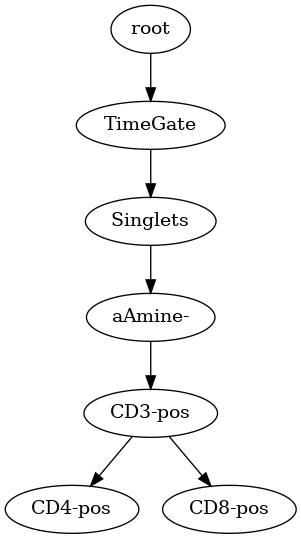

In [12]:
Image('gs.png')

#### Retrieve Gate IDs 

Remember, a gate ID is a tuple of the gate name and the gate path. We can retrieve all the gate IDs using `get_gate_ids`. There are also convenience methods to get a parent gate ID or child gate IDs from a gate ID. If the gate name of a gate ID is unambiguous, the gate path can be omitted.

In [13]:
g_strat.get_gate_ids()

[('TimeGate', ('root',)),
 ('Singlets', ('root', 'TimeGate')),
 ('aAmine-', ('root', 'TimeGate', 'Singlets')),
 ('CD3-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-')),
 ('CD4-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-', 'CD3-pos')),
 ('CD8-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-', 'CD3-pos'))]

In [14]:
g_strat.get_parent_gate_id('CD3-pos')

('aAmine-', ('root', 'TimeGate', 'Singlets'))

In [15]:
g_strat.get_child_gate_ids('CD3-pos')

[('CD4-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-', 'CD3-pos')),
 ('CD8-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-', 'CD3-pos'))]

There are a few other convenience methods for programatically traversing the gate tree to retrieve gate IDs.

#### Retrieve Gate Instances

Below we demonstrate how to retrieve a Gate instance by its gate name, which works here because the name is unambigious within this gate hierarchy.

In [16]:
g_strat.get_gate('Singlets')

PolygonGate(Singlets, vertices: 8)

In [17]:
# Get the list of gates at the root level
g_strat.get_root_gates()

[RectangleGate(TimeGate, dims: 2)]

Before we move on, there is another feature of the GatingStrategy that is important to cover: custom sample gates. Users of cytometry software with a graphical user interface (e.g. FlowJo) know that sometimes a gate's boundaries need tweaking for a particular sample. The GatingStrategy supports adding such custom gates by adding a gate with a Sample ID. 

The next tutorial will demonstrate its usage, but let's look at the docstring for the `add_gate` method to get an idea of how it works. 

In [18]:
help(fk.GatingStrategy.add_gate)

Help on function add_gate in module flowkit._models.gating_strategy:

add_gate(self, gate, gate_path, sample_id=None)
    Add a gate to the gating strategy, see `gates` module. The gate ID and gate path
    must be unique in the gating strategy. Custom sample gates may be added by specifying
    an optional sample ID. Note, the gate & gate path must already exist prior to adding
    custom sample gates.
    
    :param gate: instance from a subclass of the Gate class
    :param gate_path: complete ordered tuple of gate names for unique set of gate ancestors
    :param sample_id: text string for specifying given gate as a custom Sample gate
    
    :return: None



#### Retrieve Compensation Matrices

Compensation matrixes identified within the GatingStrategy by an ID. The `comp_matrices` attribute returns a dictionary where the IDs are the keys and the values are the Matrix instances.

In [19]:
g_strat.comp_matrices

{'Acquisition-defined': Matrix(dims: 8)}

#### Retrieve Transformations

Retrieving tranformations works in a similar way as the compensation matrices. The `transformations` attribute returns a dictionary of ID keys and transformation instances>

In [20]:
g_strat.transformations

{'scatter-lin': LinearTransform(t: 262144.0, a: 0.0),
 'logicle-default': LogicleTransform(t: 262144.0, w: 1.0, m: 4.418539922, a: 0.0),
 'Time': LinearTransform(t: 72.0, a: 0.8511997311)}

## GatingResults Class

The `gate_sample` method is used to apply a GatingStrategy to a FCS file. This method returns GatingResults instance. A GatingResults instance contains the results of applying the gating hierarchy on a single Sample. Note, a GatingResults instance is never created by the end user directly, it is only returned from applying a GatingStrategy, Session, or Workspace on a Sample (more on the Session and Workspace classes in the upcoming tutorials).

Let's load a Sample and apply the previous GatingStrategy via the `gate_sample` method (setting `verbose=True` to print out each gate as it is processed).

In [21]:
sample = fk.Sample("../../data/8_color_data_set/fcs_files/101_DEN084Y5_15_E01_008_clean.fcs")

In [22]:
gs_results = g_strat.gate_sample(sample, verbose=True)

101_DEN084Y5_15_E01_008_clean.fcs: processing gate TimeGate
101_DEN084Y5_15_E01_008_clean.fcs: processing gate Singlets
101_DEN084Y5_15_E01_008_clean.fcs: processing gate aAmine-
101_DEN084Y5_15_E01_008_clean.fcs: processing gate CD3-pos
101_DEN084Y5_15_E01_008_clean.fcs: processing gate CD4-pos
101_DEN084Y5_15_E01_008_clean.fcs: processing gate CD8-pos


In [23]:
# get the Sample ID for the GatingResults instance
gs_results.sample_id

'101_DEN084Y5_15_E01_008_clean.fcs'

### GatingResults Report

As we can see, the GatingResults class is relatively simple, and it's main purpose is to provide a Pandas DataFrame of the results via the `report` attribute. The report contains a row for every gate and includes the following columns:

* **sample**: the Sample ID of the processed Sample instance
* **gate_path**: tuple of the gate path
* **gate_name**: the name of the gate (or name of the Quadrant of a QuadrantGate)
* **gate_type**: The class name of the gate (RectangleGate, PolygonGate, etc.)
* **quadrant_parent**: Quadrant gates are a bit different, they are really a collection of gates. This field would contain the QuadrantGate name, and each Quadrant name would be in the gate_name field.
* **parent**: the gate name of the parent gate
* **count**: the absolute event count for events inside the gate
* **absolute_percent**: the percentage of events inside the gate relative to the total event count in the Sample
* **relative_percent**: the percentage of events inside the gate relative to the number of events in the parent gate
* **level**: the depth of the gate in the gate tree relative to the root of the tree (Note: root level is 0) 

In [24]:
gs_results.report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,101_DEN084Y5_15_E01_008_clean.fcs,"(root,)",TimeGate,RectangleGate,None,root,290166,99.997932,99.997932,0
1,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate)",Singlets,PolygonGate,None,TimeGate,239001,82.365287,82.366990,1
2,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets)",aAmine-,PolygonGate,None,Singlets,164655,56.743931,68.893017,2
3,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets, aAmine-)",CD3-pos,PolygonGate,None,aAmine-,133670,46.065782,81.181865,3
4,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets, aAmine-, CD3-pos)",CD4-pos,PolygonGate,None,CD3-pos,82484,28.425899,61.707189,4
5,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets, aAmine-, CD3-pos)",CD8-pos,PolygonGate,None,CD3-pos,47165,16.254153,35.284656,4


For convenience, you can get individual Sample statistics for a gate without having to filter the Pandas DataFrame

In [25]:
# Retrieve the absolute gate count.
# Remember to use the gate path if the gate name is ambiguous.
gs_results.get_gate_count('CD3-pos')

133670

In [26]:
# Or, get the absolute percent
gs_results.get_gate_absolute_percent('CD3-pos')

46.0657816743173

In [27]:
# And the same for the relative percent
gs_results.get_gate_relative_percent('CD3-pos')

81.18186511190063

### Retrieve Gate Membership

The `get_gate_membership` method returns a Boolean array representing which of the Sample events are inside the specified gate. The arguments are the same gate name and gate path to identify the gate (gate path is optional if gate name is unambiguous).

In [28]:
cd3_pos_gate_membership = gs_results.get_gate_membership('CD3-pos')

In [29]:
cd3_pos_gate_membership

array([False, False, False, ..., False, False,  True])

In [30]:
# Summing the Boolean values in the membership NumPy array gives the absolute event count of the gate
cd3_pos_gate_membership.sum()

133670

We can then use the membership array to retrieve those events from the Sample

**Note: The events we extract here are not necessarily pre-processed the same as they would be given the instructions of the gate, even if using the 'comp' or 'xform' source option.**

In [31]:
gated_raw_events = sample.get_events(source='raw')
gated_raw_events = gated_raw_events[cd3_pos_gate_membership]

In [32]:
gated_raw_events.shape

(133670, 15)

In [33]:
# Even simpler, we can use the event_mask option of the Sample.get_events method to get the same gated events
gated_raw_events = sample.get_events(source='raw', event_mask=cd3_pos_gate_membership)

In [34]:
gated_raw_events.shape

(133670, 15)

## Manually Creating Gating Strategies

In the next tutorial, we will cover how to use the `gates` module to manually build a `GatingStrategy`.